<a href="https://colab.research.google.com/github/epigos/house-prices-prediction/blob/main/catboost%20regression%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq yellowbrick category_encoders catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [3]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# sklearn models
from sklearn import metrics, model_selection

import catboost as cb

# visualizations
import shap
from yellowbrick.regressor import residuals_plot, prediction_error

In [4]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

# Load dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/house_rental_final.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   category_Flats                 17890 non-null  float64
 1   category_Detached              17890 non-null  float64
 2   category_Townhouse             17890 non-null  float64
 3   category_Duplex                17890 non-null  float64
 4   category_Mansion               17890 non-null  float64
 5   category_Semi-Detached         17890 non-null  float64
 6   bedrooms                       17890 non-null  float64
 7   bathrooms                      17890 non-null  float64
 8   floor_area                     17890 non-null  float64
 9   condition_Used                 17890 non-null  float64
 10  condition_New                  17890 non-null  float64
 11  condition_Renovated            17890 non-null  float64
 12  amenities_24-hour electricity  17890 non-null 

# CatBoost Regressor

In [ ]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [ ]:
# train-test split for model evaluation
X = df.drop(['price', 'log1p_price'], axis=1).values
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [ ]:
X_train.shape, X_test.shape

((14312, 37), (3578, 37))

In [ ]:
model = cb.CatBoostRegressor(random_seed=42, logging_level='Silent')

model = model.fit(X_train, y_train)

### Training metrics


In [ ]:
train_metrics = compute_metrics(model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.912,0.114,0.338,0.256,0.911,87.01


### Validation metrics


In [ ]:
val_metrics = compute_metrics(model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.877,0.162,0.403,0.301,0.876,85.43


# GridSearch

In [ ]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'lea

In [ ]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

grid = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 3]
}

In [ ]:
grid_search = RandomizedSearchCV(
    estimator=cb.CatBoostRegressor(random_seed=42, logging_level='Silent'), param_distributions=grid,
    refit=True, verbose=3, cv=5, scoring='r2', n_jobs=-1, n_iter=50
)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8}
Best R2 score: 0.8711650070086803


In [ ]:
best_model = grid_search.best_estimator_

train_metrics = compute_metrics(best_model, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.92,0.103,0.321,0.243,0.92,87.12


In [ ]:
val_metrics = compute_metrics(best_model, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.876,0.164,0.404,0.301,0.875,85.35


### Residual plots

In [ ]:
from yellowbrick.contrib.wrapper import wrap

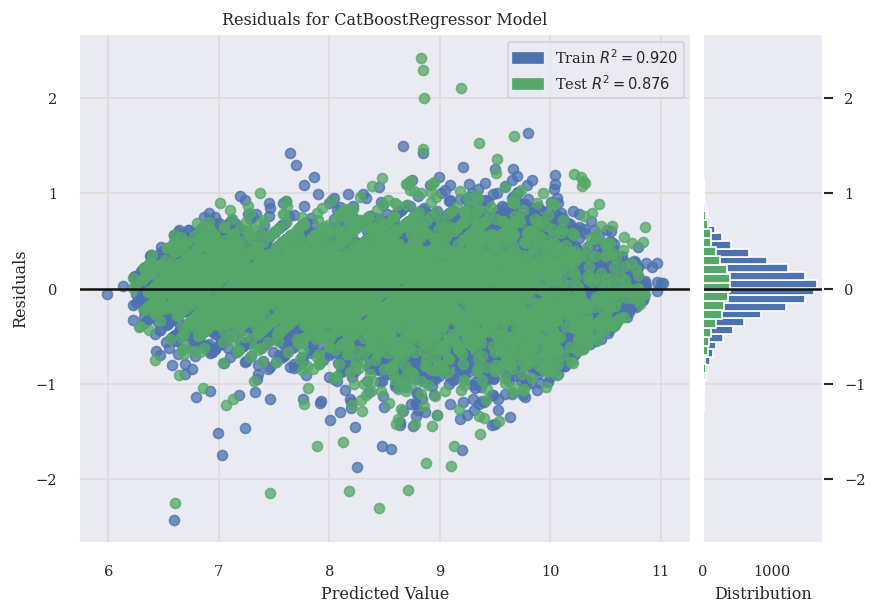

In [ ]:
visualizer = residuals_plot(
    wrap(best_model), X_train, y_train, X_test, y_test,
)

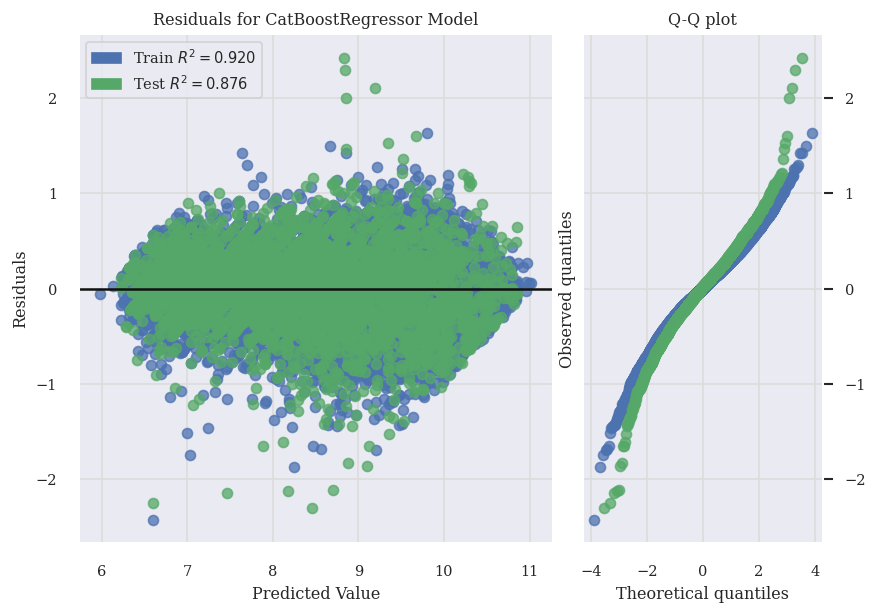

In [ ]:
visualizer = residuals_plot(
    wrap(best_model), X_train, y_train, X_test, y_test, hist=False, qqplot=True
)

The QQ-Plot shows the residuals are normally distributed, because their quantiles when plotted against quantiles of normal distribution forms a straight line.

### Prediction Error

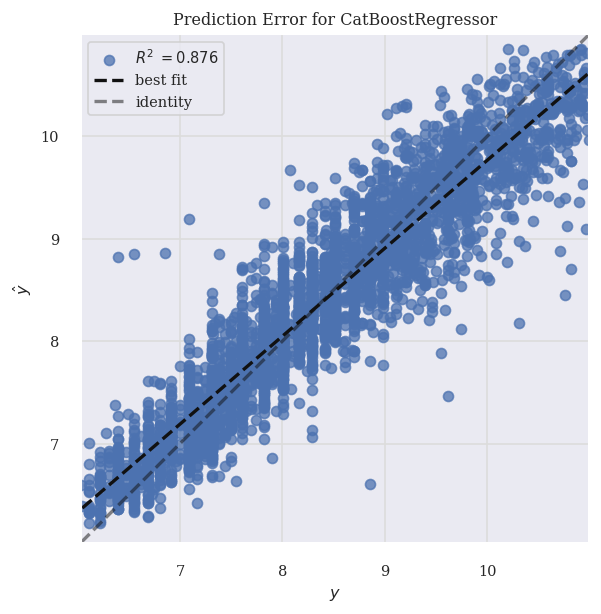

In [ ]:
visualizer = prediction_error(wrap(best_model), X_train, y_train, X_test, y_test)

## Feature importance

In [ ]:
variables = abs(best_model.feature_importances_)
coef_df = pd.DataFrame(
    {
        "Variable": df.drop(['price', 'log1p_price'], axis=1).columns,
        "Value": variables,
    }
)
n = 10
sorted_df = (
    coef_df.sort_values(by="Value", ascending=False)
    .head(n)
    .sort_values(by="Value")
)
sorted_df

,Variable,Value
33,amenities_count,1.890039
25,amenities_refrigerator,2.610764
0,category_Flats,2.823859
8,floor_area,5.291743
7,bathrooms,8.807882
13,amenities_air conditioning,8.815333
36,furnishing_Furnished,9.796574
31,lat,12.731295
6,bedrooms,14.213729
32,lng,18.455433


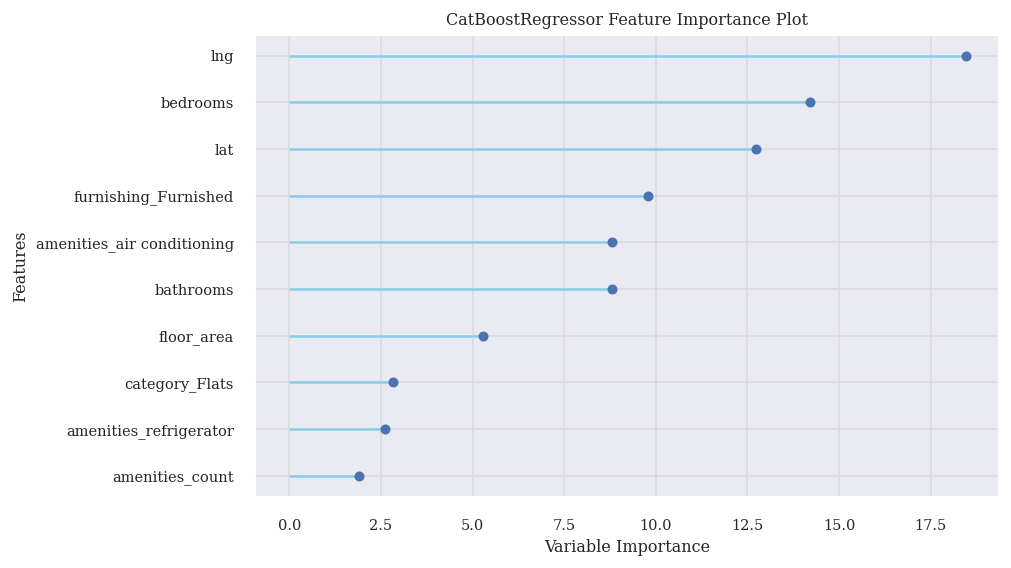

In [ ]:
my_range = range(1, len(sorted_df.index) + 1)
plt.figure(figsize=(8, 5 * (n // 10)))
plt.hlines(
    y=my_range,
    xmin=0,
    xmax=sorted_df["Value"],
    color="skyblue",
)
plt.plot(sorted_df["Value"], my_range, "o")
plt.yticks(my_range, sorted_df["Variable"])
plt.title("CatBoostRegressor Feature Importance Plot")
plt.xlabel("Variable Importance")
plt.ylabel("Features")
plt.show()

## SHAP Values

In [ ]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

In [ ]:
feature_names=coef_df.sort_values(by="Value", ascending=False)['Variable'].values
feature_names

array(['lng', 'bedrooms', 'lat', 'furnishing_Furnished',
       'amenities_air conditioning', 'bathrooms', 'floor_area',
       'category_Flats', 'amenities_refrigerator', 'amenities_count',
       'amenities_wardrobe', 'amenities_microwave', 'amenities_hot water',
       'amenities_dishwasher', 'condition_New', 'amenities_apartment',
       'amenities_24-hour electricity', 'furnishing_Unfurnished',
       'amenities_pop ceiling', 'amenities_wi-fi',
       'furnishing_Semi-Furnished', 'amenities_kitchen shelf',
       'amenities_pre-paid meter', 'category_Detached',
       'amenities_balcony', 'amenities_kitchen cabinets',
       'condition_Used', 'amenities_chandelier', 'category_Townhouse',
       'amenities_tv', 'amenities_dining area', 'amenities_tiled floor',
       'category_Duplex', 'category_Semi-Detached', 'category_Mansion',
       'parking_space', 'condition_Renovated'], dtype=object)

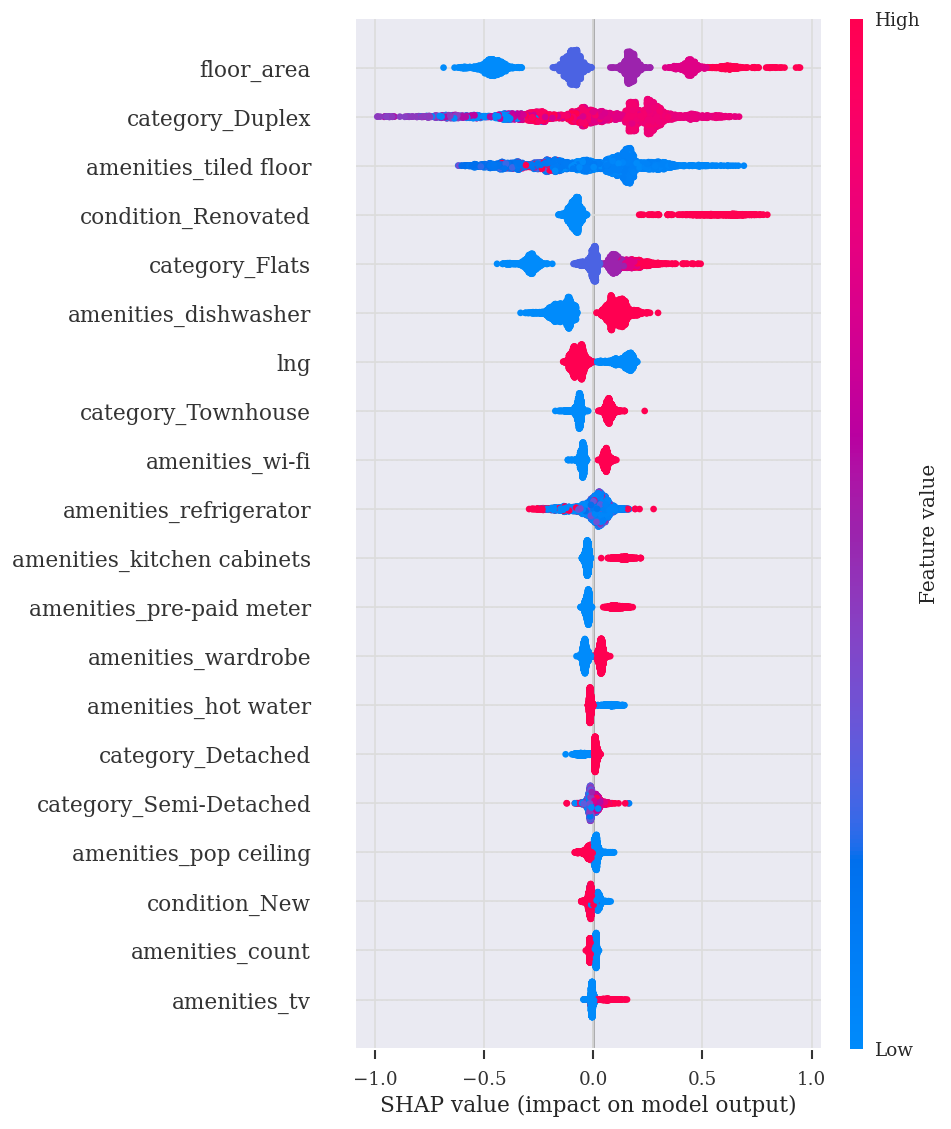

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

## Visualize decision tree

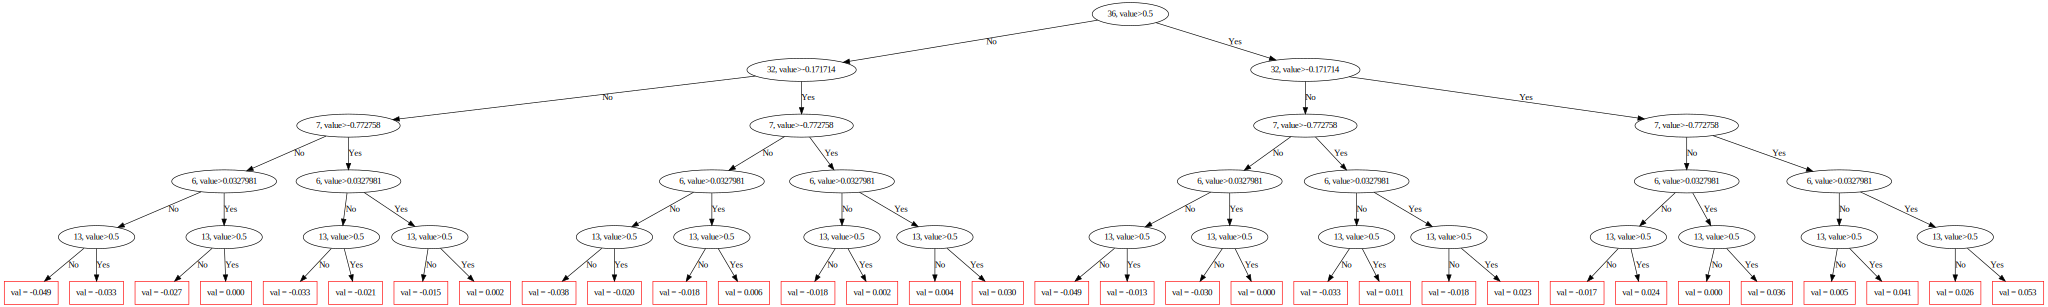

In [ ]:
best_model.plot_tree(
    tree_idx=0,
)

## Actual Predictions

In [ ]:
preds = best_model.predict(X_test)

In [ ]:
# Reverse the log transformation
actual_preds = np.expm1(preds)
actual_y_test = np.expm1(y_test)

# Compute metrics on the original scale
def compute_metrics_original_scale(y_true, y_pred):
    return pd.DataFrame([{
        "R2": round(metrics.r2_score(y_true, y_pred), 3),
        "mse": round(metrics.mean_squared_error(y_true, y_pred), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 3),
        "mae": round(metrics.mean_absolute_error(y_true, y_pred), 3),
    }])

val_metrics_original_scale = compute_metrics_original_scale(actual_y_test, actual_preds)
val_metrics_original_scale

,R2,mse,rmse,mae
0,0.728,31693580.22,5629.705,2710.083


In [ ]:
pred_df = pd.DataFrame({"actual": actual_y_test, "pred": actual_preds})
pred_df.head(10)

,actual,pred
0,2000.0,1974.762928
1,2500.0,3120.336611
2,1500.0,923.794480
3,1000.0,1188.797788
4,4000.0,5362.900587
5,3500.0,3963.539610
6,5000.0,3697.383963
7,3000.0,4063.403126
8,8000.0,8599.500714
9,1200.0,842.593364


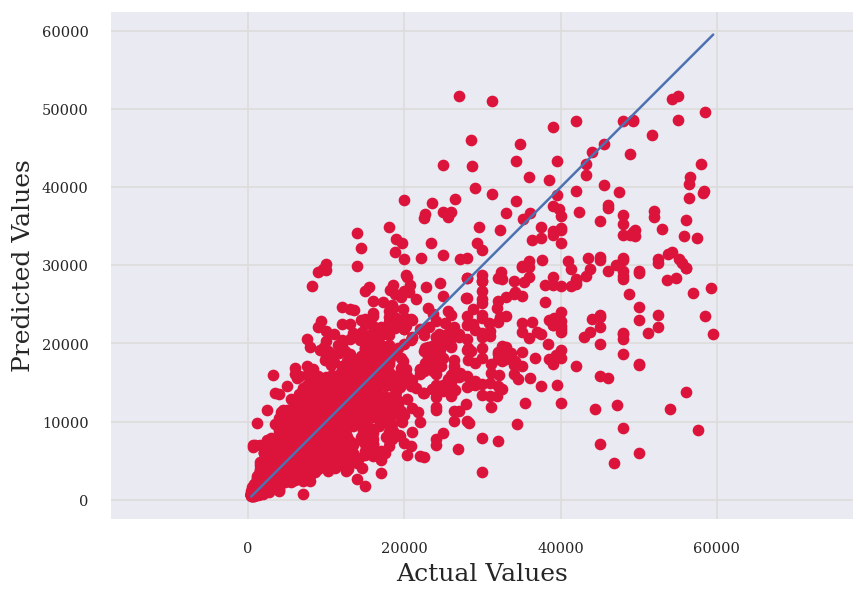

In [ ]:
plt.scatter(pred_df.actual, pred_df.pred, c='crimson')
p1 = max(max(pred_df.actual), max(pred_df.pred))
p2 = min(min(pred_df.actual), min(pred_df.pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

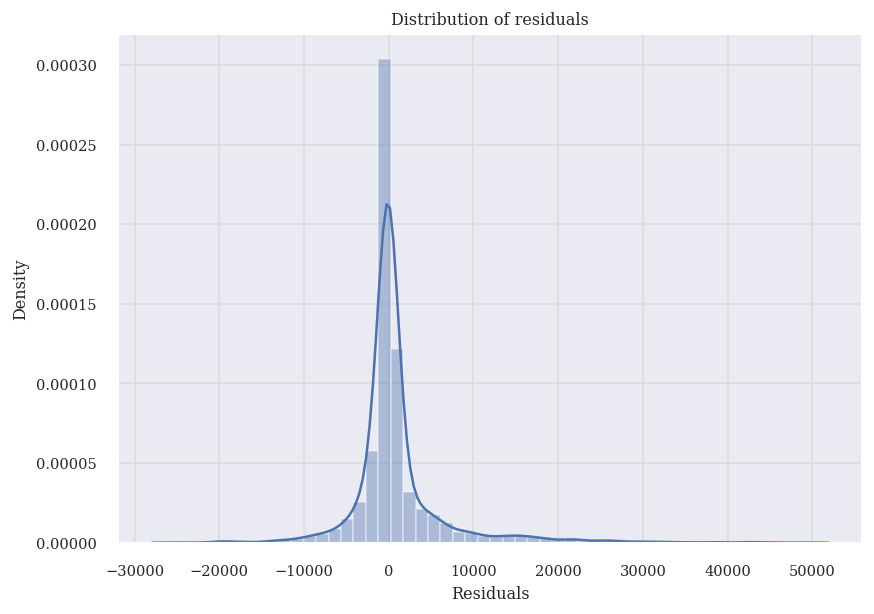

In [ ]:
sns.distplot((pred_df.actual-pred_df.pred))
plt.title('Distribution of residuals')
plt.xlabel("Residuals")
plt.show()

# Model Pipeline

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/house_rentals_cleaned.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         17890 non-null  object 
 1   bedrooms         17890 non-null  float64
 2   bathrooms        17890 non-null  float64
 3   floor_area       17890 non-null  float64
 4   condition        17890 non-null  object 
 5   amenities        17890 non-null  object 
 6   parking_space    17890 non-null  int64  
 7   lat              17890 non-null  float64
 8   lng              17890 non-null  float64
 9   amenities_count  17890 non-null  int64  
 10  furnishing       17890 non-null  object 
 11  log1p_price      17890 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


In [87]:
df['amenities'].head()

,amenities
0,"24-hour Electricity,Air Conditioning,Balcony,C..."
1,"24-hour Electricity,Air Conditioning,Apartment..."
2,"Tiled Floor,Chandelier,Dining Area,Balcony,Pop..."
3,"Pop Ceiling,Pre-Paid Meter,24-hour Electricity..."
4,"Pre-Paid Meter,Dining Area,Chandelier,Balcony,..."


In [7]:
category_cols = ["category", "condition", "furnishing"]
text_cols = ["amenities"]
bool_cols = ['parking_space']
target_columns = ['log1p_price']
numeric_cols = list(set(df.columns) - set(target_columns) - set(category_cols) - set(text_cols) - set(bool_cols))

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer


In [129]:
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_most_frequent",
            SimpleImputer(strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

def text_tokenizer(x):
    return x.split(',')

text_preprocessor = Pipeline(
    steps=[
        ("count_vectorizer", CountVectorizer(max_features=20,tokenizer=text_tokenizer, binary=True))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessor, numeric_cols),
        ("categorical", categorical_preprocessor, category_cols),
        ("text", text_preprocessor, text_cols[0]),
    ]
)

In [130]:
best_params = {'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8}

pipe = make_pipeline(preprocessor, cb.CatBoostRegressor(random_seed=42, logging_level='Silent', **best_params))
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lng', 'floor_area', 'lat',
                                                   'bathrooms',
                                                   'amenities_count',
                                                   'bedrooms']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_most_frequent',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'condition',
                                                   'furnishing']),
                                                 ('text',
                                                  Pipeline(steps=[('count_vectorizer',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=20,
                                                                                   tokenizer=<function text_tokenizer at 0x7f82e40423b0>))]),
                                                  'amenities')])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f82e4b1a4d0>)])

In [131]:
# train-test split for model evaluation
X = df.drop(columns=['log1p_price'], axis=1)
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14312 entries, 13957 to 15795
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         14312 non-null  object 
 1   bedrooms         14312 non-null  float64
 2   bathrooms        14312 non-null  float64
 3   floor_area       14312 non-null  float64
 4   condition        14312 non-null  object 
 5   amenities        14312 non-null  object 
 6   parking_space    14312 non-null  int64  
 7   lat              14312 non-null  float64
 8   lng              14312 non-null  float64
 9   amenities_count  14312 non-null  int64  
 10  furnishing       14312 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.3+ MB


In [133]:
# Fit the pipeline to your training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lng', 'floor_area', 'lat',
                                                   'bathrooms',
                                                   'amenities_count',
                                                   'bedrooms']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_most_frequent',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'condition',
                                                   'furnishing']),
                                                 ('text',
                                                  Pipeline(steps=[('count_vectorizer',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=20,
                                                                                   tokenizer=<function text_tokenizer at 0x7f82e40423b0>))]),
                                                  'amenities')])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f82e4b1a4d0>)])

In [134]:
pipe.score(X_train, y_train)

0.9207815334537437

In [135]:
pipe.score(X_test, y_test)

0.8752449519312141

In [137]:
# save the pipeline to disk

import joblib

# Assuming 'pipe' is your fitted pipeline
joblib.dump(pipe, 'house_rental_pipeline.joblib')

['house_rental_pipeline.joblib']

In [138]:
!ls -lha house_rental_pipeline.joblib

-rw-r--r-- 1 root root 4.1M Nov 21 23:02 house_rental_pipeline.joblib


In [141]:
!cp house_rental_pipeline.joblib /content/drive/MyDrive/Models/

In [142]:
pipe = joblib.load('house_rental_pipeline.joblib')
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lng', 'floor_area', 'lat',
                                                   'bathrooms',
                                                   'amenities_count',
                                                   'bedrooms']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_most_frequent',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'condition',
                                                   'furnishing']),
                                                 ('text',
                                                  Pipeline(steps=[('count_vectorizer',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=20,
                                                                                   tokenizer=<function text_tokenizer at 0x7f82e40423b0>))]),
                                                  'amenities')])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7f82e4d3ee00>)])

In [143]:
for col in category_cols:
    print(col, df[col].unique())

category ['Flats' 'Detached' 'Townhouse' 'Duplex' 'Mansion' 'Semi-Detached']
condition ['Used' 'New' 'Renovated']
furnishing ['Semi-Furnished' 'Unfurnished' 'Furnished']


In [150]:
# create a counter to count amentities in the dataset
results = Counter()
df.amenities.apply(lambda x: results.update(x.split(",")))
# create a new sub dataframe with 'amenity' and 'count'
amenity_df = pd.DataFrame(results.most_common(), columns=['amenity', 'count'])
amenity_df

,amenity,count
0,Tiled Floor,15820
1,Pre-Paid Meter,15521
2,Kitchen Cabinets,15420
3,24-hour Electricity,15255
4,Pop Ceiling,14212
5,Dining Area,11536
6,Balcony,11458
7,Kitchen Shelf,11190
8,Apartment,10499
9,Air Conditioning,9563


In [152]:
amenity_df['amenity'].values.tolist()

['Tiled Floor',
 'Pre-Paid Meter',
 'Kitchen Cabinets',
 '24-hour Electricity',
 'Pop Ceiling',
 'Dining Area',
 'Balcony',
 'Kitchen Shelf',
 'Apartment',
 'Air Conditioning',
 'Wardrobe',
 'Hot Water',
 'Dishwasher',
 'Chandelier',
 'Microwave',
 'Refrigerator',
 'Wi-Fi',
 'TV']